In [14]:
import json
import re
import pymysql
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
pd.options.display.float_format = "{:.0f}".format

In [15]:
with open('../../server/app/config.json') as json_data_file:
    data = json.load(json_data_file)
    url = data['SQLALCHEMY_DATABASE_URI']
user, password, host, database = re.match('mysql://(.*?):(.*?)@(.*?)/(.*)', url).groups()
conn = pymysql.connect(host=host,port=3306,user=user,passwd=password,db=database)

In [16]:
query="""
    SELECT  TIMESTAMP,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX0' AS MUX0,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX1' AS MUX1,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX2' AS MUX2,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX3' AS MUX3,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX4' AS MUX4,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX5' AS MUX5,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX6' AS MUX6,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX7' AS MUX7
    FROM OASIS_DATA
    WHERE NODE_ID='oasis-39732c'
    ORDER BY TIMESTAMP asc
    """
df = pd.read_sql_query(query, conn).astype(int) 

In [26]:
print("Interval:", df['TIMESTAMP'][1] - df['TIMESTAMP'][0], "secs")
print("Duration:", int(df['TIMESTAMP'].tail(1) - df['TIMESTAMP'][0])/3600, "hrs")

Interval: 60 secs
Duration: 3.05 hrs


In [21]:
df[['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].describe()

,MUX0,MUX1,MUX2,MUX3,MUX4,MUX5,MUX6,MUX7
count,184,184,184,184,184,184,184,184
mean,244,245,262,248,253,273,308,257
std,7,7,8,6,7,7,15,8
min,228,231,246,231,236,260,277,242
25%,240,241,257,244,247,269,296,250
50%,244,244,262,247,253,272,310,256
75%,249,249,268,253,259,279,320,264
max,258,257,278,260,265,286,340,272


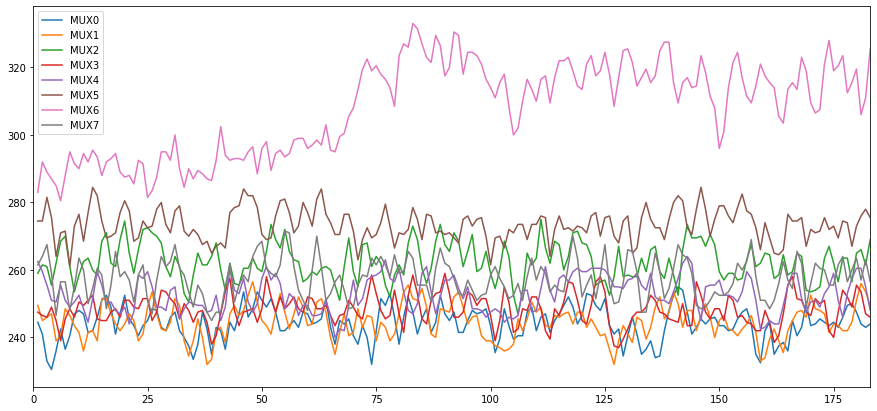

In [22]:
df[['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].rolling(2).mean().plot()